<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

# Pyosim in the cloud
## with [pyomeca](https://github.com/pyomeca/pyomeca)
Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Raw data](01.01-raw-data.ipynb) | [Contents](Index.ipynb) |

# Inverse kinematics

In [1]:
from pathlib import Path

import yaml

import numpy as np
import pandas as pd
from pyosim import Conf
from pyomeca import Analogs3d

import altair as alt

alt.data_transformers.enable("json")

DataTransformerRegistry.enable('json')

In [2]:
MODEL = "wu"
DATA = '3_static_optimization'
EXT = 'sto'

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
participants = conf.get_participants_to_process()
conf.check_confs()

Project loaded
Configuration file loaded


sarc: checked
sarc: updated in project conf
inea: checked
inea: updated in project conf
dapo: checked
dapo: updated in project conf
laug: checked
laug: updated in project conf
mars: checked
mars: updated in project conf
benl: checked
benl: updated in project conf
davo: checked
davo: updated in project conf
gatb: checked
gatb: updated in project conf
yoap: checked
yoap: updated in project conf
romm: checked
romm: updated in project conf
camb: checked
camb: updated in project conf
eved: checked
eved: updated in project conf
naus: checked
naus: updated in project conf
verc: checked
verc: updated in project conf
marh: checked
marh: updated in project conf
samn: checked
samn: updated in project conf
alef: checked
alef: updated in project conf
aimq: checked
aimq: updated in project conf
ameg: checked
ameg: updated in project conf
noel: checked
noel: updated in project conf
karm: checked
karm: updated in project conf
patm: checked
patm: updated in pr

In [8]:
data = []
for iparticipant in participants:
    data_path = conf.project_path / iparticipant / DATA
    for ifile in data_path.glob(f"*activation.{EXT}"):
        f = ifile.stem.replace(f"{MODEL}_", "")
        meta = {
            "filename": ifile.stem,
            "participant": f[:4].lower(),
            "sex": f[4],
            "height": f[-3],
            "weight": f[5:].split("H")[0],
            "trial": f[-1],
        }
        d = Analogs3d.from_sto(ifile)
        data.append(
#             d.low_pass(freq=d.get_rate, order=2, cutoff=6)
            d
            .time_normalization()
            .update_misc(meta)
            .to_dataframe(add_metadata=["misc"])
        )
data = pd.concat(data).reset_index()

print(data.shape)
data.head()

(3535, 61)


,index,LVS,TRP1,TRP2,TRP3,TRP4,RMN,RMJ1,RMJ2,SRA1,...,AC3,GH1,GH2,GH3,filename,participant,sex,height,weight,trial
0,0,0.115912,0.220804,0.079324,0.068950,0.096250,0.021128,0.012369,0.012306,0.120310,...,0.010746,-0.038046,0.008068,0.030193,wu_SarCF12H2_1_StaticOptimization_activation,sarc,F,i,12,n
1,1,0.149268,0.233830,0.082027,0.077877,0.107915,0.023714,0.012055,0.011682,0.099328,...,0.010067,-0.042076,0.009110,0.032515,wu_SarCF12H2_1_StaticOptimization_activation,sarc,F,i,12,n
2,2,0.167981,0.244646,0.083062,0.082376,0.114014,0.024934,0.011763,0.011208,0.076082,...,0.008638,-0.045252,0.010477,0.034467,wu_SarCF12H2_1_StaticOptimization_activation,sarc,F,i,12,n
3,3,0.165914,0.254312,0.083913,0.081971,0.116589,0.024441,0.011629,0.011047,0.060404,...,0.007231,-0.046914,0.011846,0.035763,wu_SarCF12H2_1_StaticOptimization_activation,sarc,F,i,12,n
4,4,0.137558,0.264763,0.086036,0.076325,0.116489,0.021992,0.011606,0.011227,0.067309,...,0.005983,-0.044695,0.012105,0.034684,wu_SarCF12H2_1_StaticOptimization_activation,sarc,F,i,12,n


In [9]:
data_wide = data.melt(id_vars=["index", "filename", "participant", "sex", "height", "weight", "trial"])
data_wide.head()

,index,filename,participant,sex,height,weight,trial,variable,value
0,0,wu_SarCF12H2_1_StaticOptimization_activation,sarc,F,i,12,n,LVS,0.115912
1,1,wu_SarCF12H2_1_StaticOptimization_activation,sarc,F,i,12,n,LVS,0.149268
2,2,wu_SarCF12H2_1_StaticOptimization_activation,sarc,F,i,12,n,LVS,0.167981
3,3,wu_SarCF12H2_1_StaticOptimization_activation,sarc,F,i,12,n,LVS,0.165914
4,4,wu_SarCF12H2_1_StaticOptimization_activation,sarc,F,i,12,n,LVS,0.137558


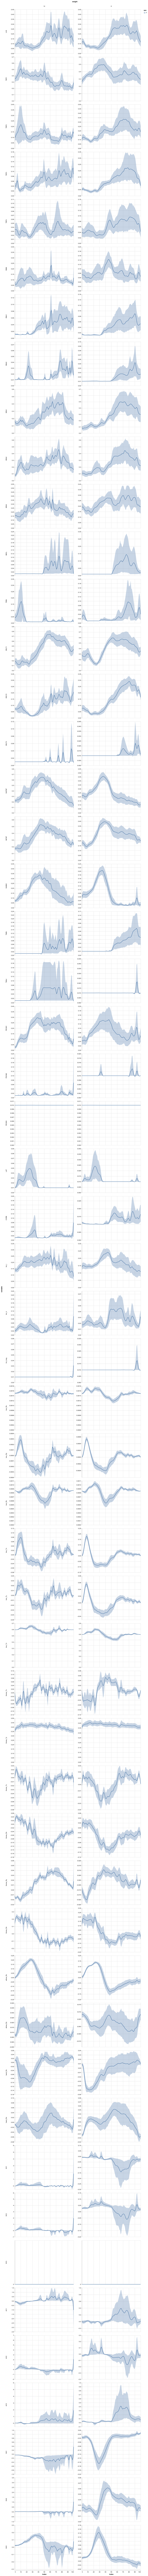

In [10]:
line = (
    alt.Chart()
    .mark_line()
    .encode(alt.X("index"), alt.Y("mean(value)", title=None), alt.Color("sex"))
)

area = (
    alt.Chart()
    .mark_area(opacity=0.3)
    .encode(alt.X("index"), alt.Y("ci0(value)"), alt.Y2("ci1(value)"), alt.Color("sex"))
)

(line + area).facet(
    data=data_wide,
    column=alt.Column("weight"),
    row=alt.Row("variable", sort=alt.Sort(d.get_labels)),
).resolve_scale(y="independent")

In [11]:
## details

line = (
    alt.Chart()
    .mark_line()
    .encode(
        alt.X("index"),
        alt.Y("mean(value)", title=None),
        alt.Color("filename"),
        alt.Tooltip("filename:N"),
    )
)

area = (
    alt.Chart()
    .mark_area(opacity=0.5, color="grey")
    .encode(alt.X("index"), alt.Y("ci0(value)"), alt.Y2("ci1(value)"))
)

(line + area).facet(
    data=data_wide,
    column=alt.Column("weight"),
    row=alt.Row("variable", sort=alt.Sort(d.get_labels)),
).resolve_scale(y="independent").save('/home/romain/Downloads/so_details.html')

In [4]:
# for iparticipant in participants:
#     data_path = conf.project_path / iparticipant / "1_inverse_kinematic"
#     for ifile in data_path.glob("*"):
#         ifile.unlink()
#         print(ifile)
# #         if ifile.stem[-3] != "2" and f[-2:] != "d0":
# #             ifile.unlink()
# #             print(ifile)
# #         else:
# #             print("safe")

/home/romain/Downloads/irsst/sarc/0_markers/SarCF12H3_1.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF6H5_1.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF12H6_1.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF12H1_2.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF6H5_3.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF12H5_3.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF6H3_2.trc
/home/romain/Downloads/irsst/sarc/0_markers/IRSST_SarCd0.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF12H4_1.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF6H3_1.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF6H2_1.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF6H1_2.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF6H4_2.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF6H6_1.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF12H2_3.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarCF6H5_2.trc
/home/romain/Downloads/irsst/sarc/0_markers/SarC

<!--NAVIGATION-->
< [Raw data](01.01-raw-data.ipynb) | [Contents](Index.ipynb) |